#Import Libraries


In [ ]:
pip install transformers==3

In [ ]:

# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda:0')
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [ ]:
!pip install contractions
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import contractions
import re
import torch
import transformers as ppb
import warnings
import logging
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings('ignore')

# specify GPU
device = torch.device("cuda")
#from transformers import BertModel, BertConfig,BertTokenizer

#Load Dataset/Git Clone

In [ ]:
!git clone https://github.com/YasaminAbbaszadegan/NLP_Forum_Recomendation_Engine.git


fatal: destination path 'NLP_Forum_Recomendation_Engine' already exists and is not an empty directory.


In [ ]:
cd /content/NLP_Forum_Recomendation_Engine/Dataset


/content/NLP_Forum_Recomendation_Engine/Dataset


In [ ]:
df=pd.read_csv('tudiabetes_20.csv',index_col=0)

In [ ]:
df.head()

,Topic Title,Category,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies
0,About the Social Clubs category,Social Clubs,[],Social Clubs are places for people with simila...,[],"Jul 26, 2018 9:24 pm",0,722,2
1,Latest Movie You’ve Seen?,Social Clubs,['Movies and Entertainment Media'],"Hi Everyone,\nWhat is the latest movie that yo...",['My wife and I see about one movie a week. L...,"Mar 12, 2019 12:45 am",0,578,5
2,Anyone doing the Broad St. Run in philly,Social Clubs,['Running'],got my notification yesterday. time to get bac...,[],0,0,0,0
3,Embroidery…. just starting out,Social Clubs,['Carefully Crafted'],Love love love creating!\nAfter years of not s...,"['That’s beautiful!', 'Thanks, so loving a dar...","Feb 4, 2019 11:31 am",4,505,2
4,Home theatre,Social Clubs,['Movies and Entertainment Media'],If anyone is approaching retirement and wonder...,[],0,0,0,0


#Preprocess 

In [ ]:
def remove_braket(x):
  x['Tags'] = x['Tags'].str.replace("[", "")
  x['Tags'] = x['Tags'].str.replace("]", "")
  x['Tags'] = x['Tags'].str.replace("'", "")
  x['Post Replies'] = x['Post Replies'].str.replace("[", "")
  x['Post Replies'] = x['Post Replies'].str.replace("]", "")
  x['Post Replies'] = x['Post Replies'].str.replace("'", "")
  x = x[x.Category != 'Social Clubs']
  x = x[x.Category != 'TuDiabetes Website']
  x = x[x.Category != 'Welcome']
  return x.reset_index(drop=True)
df=remove_braket(df)
df['comment_topic'] = df['Topic Title'] + ' ' + df['Tags'] + ' ' + df['Leading Post'] + ' ' + df['Post Replies']

In [ ]:
df_cat=df.copy()

In [ ]:
def clean_text(text):
    #Make text lowercase, remove punctuation and remove words containing numbers.
    # text=re.sub("[\(\[].*?[\)\]]", "",text)
    text=re.sub(r'#\w+ ?', '', text ) ## remove hashtag words
    text = re.sub('<.*?>','', text)
    text = re.sub('\n',' ', text)
    text = re.sub('\\n',' ', text)
    text = text.lower()
    # text = re.sub('[%s]' % re.escape(string.punctuation), '',text)#remove punctuation
   # Get rid of some additional punctuation.
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub(' — ', '', text)
    return (text)
# clean = lambda x: clean_text(x)

def full_clean(s):
  df = s.apply(lambda x: [contractions.fix(word) for word in str(x).split()])
  df= df.map(lambda x: ' '.join(x))
  df=df.apply(lambda x: clean_text(x))
  # df = df.apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop_words)]))## wont remove stop words bc they give context to the corpus
  
  return(pd.DataFrame(df))
df_cat['comment_topic_C'] =full_clean(df['comment_topic'])


In [ ]:
df_cat.head()

,Topic Title,Category,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies,comment_topic,comment_topic_C
0,Type 1 Diabetes Resources,Type 1 and LADA,,Information on this page represents a sample o...,,"Dec 21, 2009 3:04 pm",2,9.2k,6,Type 1 Diabetes Resources Information on this...,type 1 diabetes resources information on this ...
1,About the Type 1 and LADA category,Type 1 and LADA,,The Type 1 Diabetes and LADA category is inten...,,"Apr 14, 2015 5:51 pm",1,7.1k,1,About the Type 1 and LADA category The Type 1...,about the type 1 and lada category the type 1 ...
2,Are you concerned about Covid-19 Vaccine might...,Type 1 and LADA,,I am wondering if others with multiple autoimm...,"Yeah. However, given that this is a pandemic, ...","Jan 14, 2021 6:40 am",32,349,17,Are you concerned about Covid-19 Vaccine might...,are you concerned about covid-19 vaccine might...
3,Covid Vaccine - are you getting it?,Type 1 and LADA,,Hello!\nI wanted to get people who have type 1...,I am Type 2 but the question is just a relevan...,"Jan 2, 2021 8:39 pm",203,1.9k,120,Covid Vaccine - are you getting it? Hello!\nI...,covid vaccine - are you getting it? hello! i w...
4,Bolusing for pasta - big fail,Type 1 and LADA,,How do you guys bolus for pasta? I had some e...,"With pasta (any kind of spaghetti, light on th...","Jan 16, 2021 6:30 am",11,147,13,Bolusing for pasta - big fail How do you guys...,bolusing for pasta - big fail how do you guys ...


In [ ]:
my_categories = [ 'Type 1 and LADA',
'Type 2', 'Diabetes and Pregnancy', 'Community', 'Food',
'Treatment', 'Diabetes Technology']
new_DF = pd.DataFrame()

new_DF['comment_topic'] = df_cat['comment_topic_C'].apply(lambda x: str(x))
new_DF['Category'] = df_cat['Category'].apply(lambda x: str(x))

# changing class names (text) to numbers (a necessity for simpletransformers library)
new_DF['Category'] = new_DF.apply(lambda x:  my_categories.index(x['Category']),axis=1)

In [ ]:
new_DF

,comment_topic,Category
0,type 1 diabetes resources information on this ...,0
1,about the type 1 and lada category the type 1 ...,0
2,are you concerned about covid-19 vaccine might...,0
3,covid vaccine - are you getting it? hello! i w...,0
4,bolusing for pasta - big fail how do you guys ...,0
...,...,...
3502,frequent occlusions with tandem x2 a few month...,6
3503,any loopers using this button? diy closed loop...,6
3504,which infusion set? insulin pumps i have tande...,6
3505,availability of diabetes products in canada. i...,6


In [ ]:
df_cat['Category_label']=new_DF['Category']
df_cat.head()

,Topic Title,Category,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies,comment_topic,comment_topic_C,Category_label
0,Type 1 Diabetes Resources,Type 1 and LADA,,Information on this page represents a sample o...,,"Dec 21, 2009 3:04 pm",2,9.2k,6,Type 1 Diabetes Resources Information on this...,type 1 diabetes resources information on this ...,0
1,About the Type 1 and LADA category,Type 1 and LADA,,The Type 1 Diabetes and LADA category is inten...,,"Apr 14, 2015 5:51 pm",1,7.1k,1,About the Type 1 and LADA category The Type 1...,about the type 1 and lada category the type 1 ...,0
2,Are you concerned about Covid-19 Vaccine might...,Type 1 and LADA,,I am wondering if others with multiple autoimm...,"Yeah. However, given that this is a pandemic, ...","Jan 14, 2021 6:40 am",32,349,17,Are you concerned about Covid-19 Vaccine might...,are you concerned about covid-19 vaccine might...,0
3,Covid Vaccine - are you getting it?,Type 1 and LADA,,Hello!\nI wanted to get people who have type 1...,I am Type 2 but the question is just a relevan...,"Jan 2, 2021 8:39 pm",203,1.9k,120,Covid Vaccine - are you getting it? Hello!\nI...,covid vaccine - are you getting it? hello! i w...,0
4,Bolusing for pasta - big fail,Type 1 and LADA,,How do you guys bolus for pasta? I had some e...,"With pasta (any kind of spaghetti, light on th...","Jan 16, 2021 6:30 am",11,147,13,Bolusing for pasta - big fail How do you guys...,bolusing for pasta - big fail how do you guys ...,0


In [ ]:
# label_counts = pd.DataFrame(df_cat['Category'].value_counts())
# label_counts


In [ ]:
# label_values = list(label_counts.index)
# order = list(pd.DataFrame(df_cat['Category_label'].value_counts()).index)
# label_values = [l for _,l in sorted(zip(order, label_values))]

# label_values

#Shorten text

BERT has the limitation of inputting longer than a few hundred words
max_length=512

https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd

One of the limitations of BERT is on the application when you have long inputs because, in BERT, the self-attention layer has a quadratic complexity O(n²) in terms of the sequence length n (see this link). In this post, I followed the main ideas of this paper in order to know how to overcome this limitation, when you want to use BERT over long sequences of text.

In this article as the [paper](https://arxiv.org/abs/1910.10781) suggests, we are going to segment the input into smaller text and feed each of them into BERT, it means for each row, we will split the text in order to have some smaller text (200 words long each )
We must split it into a chunk of 200 words each, with 50 words overlappedApplying this function to the review_text column of the dataset would help us get the dataset where every row has a list of string of around 200-word length.


In [ ]:
def get_split(text1):
  l_total=[]
  l_partial=[]
  if len(text1.split())//150>0:
    n=len(text1.split())//150
  else:
    n=1
  for w in range(n):
    if w==0:
      l_partial=text1.split()[:500]
      l_total.append(" ".join(l_partial))
    else:
      l_partial=text1.split()[w*150:w*150+200]
      l_total.append(" ".join(l_partial))
    return l_total[0]

In [ ]:
new_DF['comment_topic']=new_DF['comment_topic'].apply(get_split)

In [ ]:
new_DF.head()

,comment_topic,Category
0,type 1 diabetes resources information on this ...,0
1,about the type 1 and lada category the type 1 ...,0
2,are you concerned about covid-19 vaccine might...,0
3,covid vaccine - are you getting it? hello! i w...,0
4,bolusing for pasta - big fail how do you guys ...,0


In [ ]:
new_DF.Category.nunique()

7

#Display_Token_Len_after_Shorten

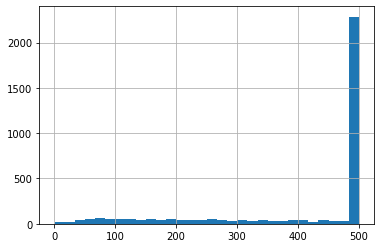

In [ ]:
seq_len = [len(i.split()) for i in new_DF['comment_topic']]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
texts = new_DF['comment_topic'].values
labels = new_DF['Category'].values

In [ ]:
text_lengths = [len(texts[i].split()) for i in range(len(texts))]
print(min(text_lengths))
print(max(text_lengths))

1
500


In [ ]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

Original Text:  type 1 diabetes resources information on this page represents a sample of the content available online for people with type 1 diabetes and lada, curated by members of the community.. this is not an exhaustive list of the resources offered online, but may be viewed as a good place to begin your search. general information a good place to start getting familiar with type 1 diabetes. what is type 1 diabetes? 151 what is diabetes? the difference between type 1 and type 2 102 us centers for disease control diabetes resources 35 positive autoantibody tests indicate type 1 autoimmune diabetes 64 how to properly and safely dispose of needles 51 other resources type 1 diabetes education 81 (integrated diabetes services) diatribe 52 - research and product news for pwd children with diabetes 82 strategies for insulin injection therapy in diabetes self-management (aade) act1: adults coping with type 1 diabetes 141 type 1 diabetes section 50 (islets of hope) taking control of your d

#PAD

In [ ]:
text_ids = [tokenizer.encode(text, max_length=500, pad_to_max_length=True) for text in texts]

print(text_ids[0])

[101, 2828, 1015, 14671, 4219, 2592, 2006, 2023, 3931, 5836, 1037, 7099, 1997, 1996, 4180, 2800, 3784, 2005, 2111, 2007, 2828, 1015, 14671, 1998, 14804, 2050, 1010, 17940, 2011, 2372, 1997, 1996, 2451, 1012, 1012, 2023, 2003, 2025, 2019, 15095, 3512, 2862, 1997, 1996, 4219, 3253, 3784, 1010, 2021, 2089, 2022, 7021, 2004, 1037, 2204, 2173, 2000, 4088, 2115, 3945, 1012, 2236, 2592, 1037, 2204, 2173, 2000, 2707, 2893, 5220, 2007, 2828, 1015, 14671, 1012, 2054, 2003, 2828, 1015, 14671, 1029, 16528, 2054, 2003, 14671, 1029, 1996, 4489, 2090, 2828, 1015, 1998, 2828, 1016, 9402, 2149, 6401, 2005, 4295, 2491, 14671, 4219, 3486, 3893, 8285, 4630, 12322, 7716, 2100, 5852, 5769, 2828, 1015, 8285, 5714, 23041, 2063, 14671, 4185, 2129, 2000, 7919, 1998, 9689, 27764, 1997, 17044, 4868, 2060, 4219, 2828, 1015, 14671, 2495, 6282, 1006, 6377, 14671, 2578, 1007, 22939, 18886, 4783, 4720, 1011, 2470, 1998, 4031, 2739, 2005, 1052, 21724, 2336, 2007, 14671, 6445, 9942, 2005, 22597, 13341, 7242, 1999, 14671

In [ ]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))

500
500


#Mask

In [ ]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)


In [ ]:

print(att_masks[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#Split

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=42, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=111, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=42, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=111, test_size=0.5)

In [ ]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([2805, 500])
torch.Size([351, 500])
torch.Size([351, 500])
torch.Size([2805])
torch.Size([351])
torch.Size([351])
torch.Size([2805, 500])
torch.Size([351, 500])
torch.Size([351, 500])


#TensorDataset, RandomSampler,SequentialSampler, DataLoader. 

In [ ]:
#WeightedRandomSampler implements a sample weight, which can be used to balance the batches for an imbalanced dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)#For feeding training data, which drives model weights updates, we use the RandomSampler
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#To feed data into the model for training, we use Pytorch’s Dataset, DataLoader, and Sampler. . 
val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)#For feeding the validation data we can use the SequentialSampler.
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

#DistilBERT Model

In [ ]:
#Here we instantiate our model class. We use a compact version, that is trained through model distillation from a base BERT model and modified to include a classification layer at the output. This compact version has 6 transformer layers instead of 12 as in the original BERT model. Please see here for more details.
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig

num_labels = len(set(labels))

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
                                                            output_attentions=False, output_hidden_states=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model), '\n', model)

Number of trainable parameters: 66958855 
 DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (drop

In [ ]:
[n for n, p in model.named_parameters()]


['distilbert.embeddings.word_embeddings.weight',
 'distilbert.embeddings.position_embeddings.weight',
 'distilbert.embeddings.LayerNorm.weight',
 'distilbert.embeddings.LayerNorm.bias',
 'distilbert.transformer.layer.0.attention.q_lin.weight',
 'distilbert.transformer.layer.0.attention.q_lin.bias',
 'distilbert.transformer.layer.0.attention.k_lin.weight',
 'distilbert.transformer.layer.0.attention.k_lin.bias',
 'distilbert.transformer.layer.0.attention.v_lin.weight',
 'distilbert.transformer.layer.0.attention.v_lin.bias',
 'distilbert.transformer.layer.0.attention.out_lin.weight',
 'distilbert.transformer.layer.0.attention.out_lin.bias',
 'distilbert.transformer.layer.0.sa_layer_norm.weight',
 'distilbert.transformer.layer.0.sa_layer_norm.bias',
 'distilbert.transformer.layer.0.ffn.lin1.weight',
 'distilbert.transformer.layer.0.ffn.lin1.bias',
 'distilbert.transformer.layer.0.ffn.lin2.weight',
 'distilbert.transformer.layer.0.ffn.lin2.bias',
 'distilbert.transformer.layer.0.output_laye

In [ ]:

# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)



learning_rate = 1e-5
adam_epsilon = 1e-8

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 

no_decay = ['bias', 'LayerNorm.weight']
 # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
     # Filter for parameters which *do* include those.
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 10
total_steps = len(train_dataloader) * num_epochs
'''
adjusts the learning rate based on number of epochs
Warm up steps is a parameter which is used to lower
the learning rate in order to reduce the impact of deviating the model from learning on sudden new data set
By default, number of warm up steps is 0.

Then you make bigger steps, because you are probably not near the minima.
But as you are approaching the minima, you make smaller steps to converge to it.
'''
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

import numpy as np
import random

seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch

model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:

# evaluate model:
model.eval()

with torch.no_grad():
    ...
    out_data = model(data)
    ...
BUT, don't forget to turn back to training mode after eval step:

# training step
...
model.train()
...

In [ ]:
train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()
''''
Train_DataLoader
Unpack this training batch from our dataloader. 
'''''
    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):

    '''
    zero out the gradients so that you do the parameter update correctly.
    Else the gradient would point in some other direction than the intended direction towards the minimum 
    '''
        optimizer.zero_grad()
        model.train()
        '''
        Move input and label tensors to the GPU
        '''
        mb_x = mb_x.to(device) #id
        mb_m = mb_m.to(device) #mask
        mb_y = mb_y.to(device) #target
        
        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        #Calculate the loss
        loss = outputs[0]
        '''
        perform backward pass throght the network to calculate the gradient
        '''
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.data / num_mb_train
    
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
 '''
 Val_dataloader
 Unpack this Validating batch from our dataloader. 
 turn off gradients
 '''
 '''
Since we're not updating our parameters in the validation pass,
we can speed up the by turning off gradients using torch.no_grad()   
 '''  
     # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        
        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)
        
            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
            #loss = model_loss(outputs[1], mb_y)
            
            val_loss += loss.data / num_mb_val
            
        print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
        val_losses.append(val_loss.cpu())
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')



Train loss after itaration 1: 1.708543
Validation loss after itaration 1: 1.352705
Time: 2m 19s

Train loss after itaration 2: 1.148504
Validation loss after itaration 2: 0.995975
Time: 2m 26s

Train loss after itaration 3: 0.879364
Validation loss after itaration 3: 0.869749
Time: 2m 27s

Train loss after itaration 4: 0.732512
Validation loss after itaration 4: 0.805549
Time: 2m 27s

Train loss after itaration 5: 0.638703
Validation loss after itaration 5: 0.770404
Time: 2m 27s

Train loss after itaration 6: 0.570278
Validation loss after itaration 6: 0.765594
Time: 2m 27s

Train loss after itaration 7: 0.521843
Validation loss after itaration 7: 0.762436
Time: 2m 27s

Train loss after itaration 8: 0.481859
Validation loss after itaration 8: 0.762419
Time: 2m 27s

Train loss after itaration 9: 0.448811
Validation loss after itaration 9: 0.770299
Time: 2m 27s

Train loss after itaration 10: 0.435203
Validation loss after itaration 10: 0.773624
Time: 2m 27s


In [ ]:
ls

model/  NLP_Forum_Recomendation_Engine/  tudiabetes_20.csv


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/Stemaway/Module5_notebook

/content/gdrive/MyDrive/Stemaway/Module5_notebook


#Save Model

In [ ]:
#After training, we can save the model and necessary configuration parameters,
# to recreate it later and use it to score the test data. Here we also save the losses computed from both training and validation data.
import pickle
import os

out_dir = './model'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

with open(out_dir + '/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)
    
with open(out_dir + '/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

In [ ]:
out_dir = './model'

model = DistilBertForSequenceClassification.from_pretrained(out_dir)
# load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(out_dir , 
                                                        do_lower_case=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with open(out_dir + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(out_dir + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

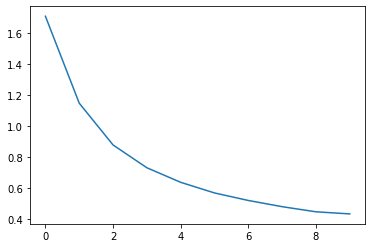

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)


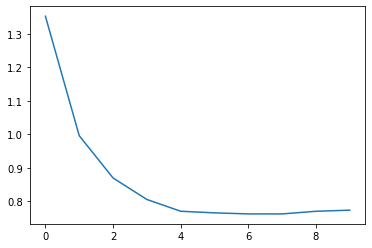

In [ ]:
plt.figure()
plt.plot(val_losses)

In [ ]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)

In [ ]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

In [ ]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7606837606837606


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in my_categories]))

                        precision    recall  f1-score   support

       Type 1 and LADA       0.50      0.49      0.49        41
                Type 2       0.52      0.71      0.60        48
Diabetes and Pregnancy       0.98      1.00      0.99        51
             Community       0.84      0.58      0.69        55
                  Food       0.89      0.78      0.83        50
             Treatment       0.81      0.82      0.81        56
   Diabetes Technology       0.82      0.90      0.86        50

              accuracy                           0.76       351
             macro avg       0.77      0.75      0.75       351
          weighted avg       0.78      0.76      0.76       351



In [ ]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[20 10  1  0  0  3  7]
 [ 6 34  0  3  2  3  0]
 [ 0  0 51  0  0  0  0]
 [ 7  8  0 32  3  2  3]
 [ 1  6  0  2 39  2  0]
 [ 2  7  0  1  0 46  0]
 [ 4  0  0  0  0  1 45]]
Normalized confusion matrix
[[0.49 0.24 0.02 0.   0.   0.07 0.17]
 [0.12 0.71 0.   0.06 0.04 0.06 0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.13 0.15 0.   0.58 0.05 0.04 0.05]
 [0.02 0.12 0.   0.04 0.78 0.04 0.  ]
 [0.04 0.12 0.   0.02 0.   0.82 0.  ]
 [0.08 0.   0.   0.   0.   0.02 0.9 ]]


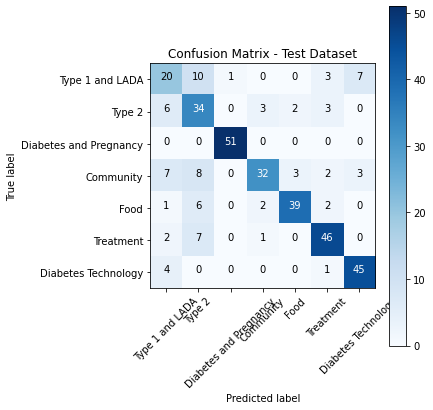

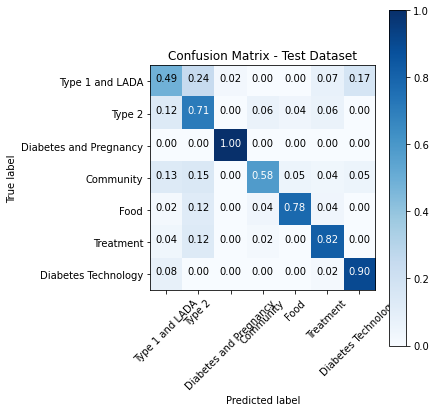

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=my_categories, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=my_categories, title='Confusion Matrix - Test Dataset', normalize=True)

#Get_Recommendations

In [ ]:
max_length=250
my_categories = [ 'Type 1 and LADA',
'Type 2', 'Diabetes and Pregnancy', 'Community', 'Food',
'Treatment', 'Diabetes Technology']
def Get_Recommendations(text,n):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    p=probs.tolist()[0]

    for i in probs.argsort(descending=True).tolist()[0][:n]:
      
      print(my_categories[i],round(p[i], 4))
      print('https://forum.tudiabetes.org/c/'+my_categories[i].lower().strip().replace(' ', '-'))


In [ ]:
text = """
I love Dexcom, I have been using it since September.
I got G5.There are some things I like about it and some not yet.
Also, Dexom just released newupdate for iPhone allowing almost full Apple Watch Integration, cant beat that
"""
print(Get_Recommendations(text,n=3))

Diabetes Technology 0.8367
https://forum.tudiabetes.org/c/diabetes-technology
Type 1 and LADA 0.0921
https://forum.tudiabetes.org/c/type-1-and-lada
Type 2 0.018
https://forum.tudiabetes.org/c/type-2
None


In [ ]:

text = """
My uncle just found out he has diabetes. he is visiting me tomorrow and I dont know what to serve dinner? does anyone have any diabetes friendly recipe suggestions?

"""
print(Get_Recommendations(text,n=3))

Food 0.9043
https://forum.tudiabetes.org/c/food
Type 2 0.0245
https://forum.tudiabetes.org/c/type-2
Treatment 0.0202
https://forum.tudiabetes.org/c/treatment
None


In [ ]:
text = """
I have high blood suger and my doctor told me I have Type 1 diabetes. What should I avoid. Any tips on good diets and recipes?
"""
print(Get_Recommendations(text,n=3))

Food 0.7418
https://forum.tudiabetes.org/c/food
Type 2 0.1289
https://forum.tudiabetes.org/c/type-2
Treatment 0.0519
https://forum.tudiabetes.org/c/treatment
None


In [ ]:
#https://forum.tudiabetes.org/t/new-beyond-type-2-app/86236
text = """

Have you checked out the Beyond Type 2 Community - a new app and online community for everyone with Type 2 diabetes to connect?

Together, we’re building a safe space to share ideas, stories, resources, and perspectives in English and Spanish, for not only living with T2D but thriving with it.

Download the Beyond Type 2 App from your mobile App Store or access it on any browser at community.beyondtype2.org 3.

Please let me know if you have any questions!"""
print(Get_Recommendations(text,n=3))

Type 2 0.7234
https://forum.tudiabetes.org/c/type-2
Type 1 and LADA 0.0809
https://forum.tudiabetes.org/c/type-1-and-lada
Treatment 0.0781
https://forum.tudiabetes.org/c/treatment
None


In [ ]:
#https://www.diabetes.co.uk/forum/threads/pregnant-with-non-diabetic-reactive-hypoglycaemia.180045/
text = """
Hello everyone,

Has anyone been pregnant with this? As I’m currently pregnant and monitored my blood sugar for two weeks at around eight weeks which was all fine, I’ve got to monitor again when I get to 28 weeks to check for gestational diabetes and I’ve been trying to avoid sugar as much as I can but sometimes I just want a brownie. Would there be any damage done to the baby from the occasional low?

I’ve not had a lot of support from the midwives, not through any fault of their own but they’d never even heard of this before and the diabetes team didn’t seem to know much about it either so I’d love to speak to anyone who’s been through pregnancy with it."""
print(Get_Recommendations(text,n=3))

Diabetes and Pregnancy 0.9515
https://forum.tudiabetes.org/c/diabetes-and-pregnancy
Type 1 and LADA 0.0105
https://forum.tudiabetes.org/c/type-1-and-lada
Type 2 0.0096
https://forum.tudiabetes.org/c/type-2
None


In [ ]:
text = """
Hi all, I’m considering loading up an old pump with symlin. 
I am already pumping insulin. My question: do people really think it is necessary to have TWO sites- one for insulin and one for symlin? 
Would it be possible to just bolus the symlin through the same site? (and yes, I know they aren’t SUPPOSED to be mixed…) Any thoughts would be appreciated. 
Thanks,Ruth"""
print(Get_Recommendations(text,n=3))

Type 1 and LADA 0.4204
https://forum.tudiabetes.org/c/type-1-and-lada
Diabetes Technology 0.1988
https://forum.tudiabetes.org/c/diabetes-technology
Treatment 0.1722
https://forum.tudiabetes.org/c/treatment
None



https://github.com/vilcek/fine-tuning-BERT-for-text-classification/blob/master/02-data-classification.ipynb